# Covid-19 Forecasting Project

A forecasting model for Covid-19 deaths was created using Prophet - an open source library published by facebook. The model uses confirmed positive cases as a predictor variable for deaths in each state

In [1]:
import pandas as pd  
import numpy as np  
import os
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
class suppress_stdout_stderr(object):
    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

with suppress_stdout_stderr(): 
    from fbprophet import Prophet

## Import Data from https://covidtracking.com/data/download

In [4]:
states_url = 'https://covidtracking.com/api/v1/states/daily.csv'
states_data = pd.read_csv(states_url) 

In [5]:
states_data

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200831,AK,6125.0,342505.0,NaN,39.0,NaN,NaN,NaN,8.0,...,348630,0,0,cf39874094a3ac9c4c3b69e94b68927b52a862eb,0,0,0,0,0,NaN
1,20200831,AL,126058.0,859229.0,NaN,1004.0,14267.0,NaN,1474.0,NaN,...,985287,20,0,7547348e99fc537845e193fe2c58d552b40036cb,0,0,0,0,0,NaN
2,20200831,AR,61224.0,665811.0,NaN,420.0,4213.0,NaN,NaN,87.0,...,727035,13,31,6a343a185910575b6b3dc7204110439160baf877,0,0,0,0,0,NaN
3,20200831,AS,0.0,1514.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1514,0,0,8f3c57405a00039abce1cf8f2f71703761321707,0,0,0,0,0,NaN
4,20200831,AZ,201835.0,1002594.0,NaN,768.0,21405.0,256.0,NaN,152.0,...,1204429,-1,-16,3410711ea86edea436f3bf920d6fef2b765a927c,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10117,20200124,WA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,6f40087f42d06db4121e09b184785b4110cd4df8,0,0,0,0,0,NaN
10118,20200123,MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,c84abd17d6845385fcfbf5b9603dc7694a807064,0,0,0,0,0,NaN
10119,20200123,WA,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,978c05d8a7a9d46e9fa826d83215f5b9732f2c6d,0,0,0,0,0,NaN
10120,20200122,MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,46dfacd26597d739a2e962d50bf5b49624bc0608,0,0,0,0,0,NaN


Combine all positive cases and deaths for each state AND date

In [6]:
deaths_project = states_data.groupby(['date','state'], as_index=False).sum()
deaths_project.rename(columns={'date':'ds', 'deathIncrease':'y'}, inplace=True)
deaths_project['ds'] = deaths_project['ds'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
deaths_project

,ds,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResultsIncrease,posNeg,y,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,2020-01-22,MA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
1,2020-01-22,WA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
2,2020-01-23,MA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
3,2020-01-23,WA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
4,2020-01-24,MA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10117,2020-08-31,VT,1624.0,134097.0,0.0,8.0,0.0,0.0,0.0,0.0,...,2446,135721,0,0,0,0,0,0,0,0.0
10118,2020-08-31,WA,74320.0,1387034.0,0.0,340.0,6740.0,0.0,0.0,51.0,...,0,1461354,0,0,0,0,0,0,0,0.0
10119,2020-08-31,WI,80568.0,1172854.0,157.0,287.0,5817.0,104.0,1020.0,0.0,...,3820,1253422,0,13,0,0,0,0,0,0.0
10120,2020-08-31,WV,10250.0,425797.0,0.0,139.0,0.0,49.0,0.0,23.0,...,4925,436047,1,0,0,0,0,0,0,0.0


Create data frame with positive coronavirus increases and date for each state. This will be used to create regressor values in the Prophet model later.

In [7]:
columns = ['positiveIncrease', 'state', 'ds']
positiveIncrease_df = deaths_project[columns]
positiveIncrease_df

,positiveIncrease,state,ds
0,0,MA,2020-01-22
1,0,WA,2020-01-22
2,0,MA,2020-01-23
3,0,WA,2020-01-23
4,0,MA,2020-01-24
...,...,...,...
10117,8,VT,2020-08-31
10118,0,WA,2020-08-31
10119,268,WI,2020-08-31
10120,140,WV,2020-08-31


# Build Prophet Model

Covid-19 deaths is often described as a "lagging indicator" to confirmed positive cases as it takes several weeks after diagnosis for patients to die. The Harvard School of Public Health demonstrated in a working paper that deaths often occur 2-8 weeks after the onset of Covid-19 symptoms.  

To account for this variable range in lag between cases and deaths, the Prophet Model will include a 5-day moving average of reported positive coronavirus cases as regressor values. This value is then shifted 21 days to compare deaths with the reported cases 3 weeks prior. 

Model Diagnostics are included in the last section of notebook (in progress).

In [8]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 5-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=5).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)
    m.add_regressor('Moving_Average')
    m.fit(group)
    future = m.make_future_dataframe(periods=21, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 21 days 
    future['Moving_Average'] = future['Moving_Average'].shift(21)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    # Calculate Mean Absolute Error for each state and append to a list
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    #print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


[[]]

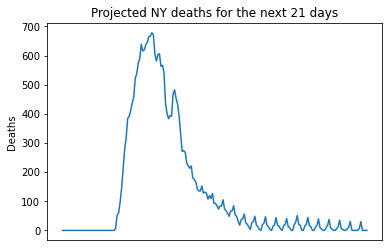

In [9]:
deaths_project_df[deaths_project_df < 0] = 0
deaths_project_df.reset_index(level=0, inplace=True)

ax = sns.lineplot(x="ds", y="yhat_NY", data = deaths_project_df)
ax.set_title('Projected NY deaths for the next 21 days')
ax.set_xlabel('')
ax.set_ylabel('Deaths')
ax.set(xticks=[])

Due to how deaths are reported, the graphs are often oscillating with the crest occuring mid-week and trough on the weekends. To smooth the graph, the 7-day moving average will be calculated

[[]]

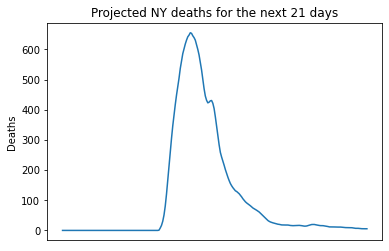

In [10]:
#Create 7-day moving average to smooth graph
deaths_project_FINAL = deaths_project_df
deaths_project_FINAL = deaths_project_FINAL.fillna(0)
deaths_project_FINAL = deaths_project_FINAL.set_index('ds')
deaths_project_FINAL = deaths_project_FINAL.rolling(window=7).mean()
deaths_project_FINAL = deaths_project_FINAL.reset_index()
deaths_project_FINAL = deaths_project_FINAL.fillna(0)

ax = sns.lineplot(x="ds", y="yhat_NY", data = deaths_project_FINAL)
ax.set_title('Projected NY deaths for the next 21 days')
ax.set_xlabel('')
ax.set_ylabel('Deaths')
ax.set(xticks=[])

In [11]:
deaths_project_FINAL

,ds,yhat_AK,yhat_AL,yhat_AR,yhat_AS,yhat_AZ,yhat_CA,yhat_CO,yhat_CT,yhat_DC,...,yhat_TN,yhat_TX,yhat_UT,yhat_VA,yhat_VI,yhat_VT,yhat_WA,yhat_WI,yhat_WV,yhat_WY
0,2020-01-22,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-01-23,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-01-24,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-01-25,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-01-26,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2020-09-17,0.337188,20.049641,11.850179,0.0,49.162506,137.630463,2.907771,5.619630,0.310445,...,26.310229,228.906128,4.029072,8.474142,0.203649,0.025685,5.267399,5.312855,2.823819,0.344104
240,2020-09-18,0.339213,20.666348,11.924442,0.0,49.215373,138.206660,2.900382,6.560513,0.312003,...,26.494365,229.099312,4.046767,8.654543,0.193041,0.025685,4.916648,5.309110,2.843663,0.346209
241,2020-09-19,0.341316,21.051583,11.987231,0.0,49.217002,138.782116,2.900382,6.560513,0.335100,...,26.686977,230.136306,4.069513,8.884211,0.183839,0.025685,4.758106,5.298090,2.863807,0.348011
242,2020-09-20,0.344668,21.771303,12.048907,0.0,49.272796,139.349730,2.900382,6.560513,0.335100,...,26.868221,231.255326,4.092690,9.048189,0.179283,0.025685,4.889369,5.301245,2.884367,0.349800


In [20]:
today = datetime.today()
current_date = today.strftime("%Y-%m-%d")
current_date

'2020-08-31'

## Export to Google Sheets API

In [155]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g

In [156]:
scope = ["https://spreadsheets.google.com/feeds","https://www.googleapis.com/auth/drive"]
credentials = ServiceAccountCredentials.from_json_keyfile_name("covid-project-286507-4067516cf92b.json", scopes=scope)
gc = gspread.authorize(credentials)
spreadsheet_key= "1O86g7PnDxIYn9kpC_LA9DuC56rB_A-deUo1LtltRFOo"

In [157]:
wks_name = "Test"
d2g.upload(deaths_project_FINAL, spreadsheet_key, wks_name, credentials=credentials, row_names=True)
print("Data upload success")

Data upload success


In [79]:
deaths_project_FINAL

,ds,yhat_AK,yhat_AL,yhat_AR,yhat_AS,yhat_AZ,yhat_CA,yhat_CO,yhat_CT,yhat_DC,...,yhat_TN,yhat_TX,yhat_UT,yhat_VA,yhat_VI,yhat_VT,yhat_WA,yhat_WI,yhat_WV,yhat_WY
0,2020-01-22,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.158170,0.000000,0.000000,0.000000
1,2020-01-23,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-01-24,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.998828,0.000000,0.000000,0.000000
3,2020-01-25,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.432659,0.000000,0.000000,0.000000
4,2020-01-26,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.357180,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2020-09-30,0.385013,27.803416,13.689991,0.0,68.905566,173.452812,7.471720,10.091201,0.617726,...,32.414632,289.907238,4.283335,11.010320,0.313066,0.000000,6.368451,5.467819,3.000893,0.380615
253,2020-10-01,0.183499,23.562340,12.565810,0.0,59.741311,176.360671,1.685088,10.059207,0.405241,...,33.813110,280.735986,3.270022,7.814665,0.199484,0.150341,3.730664,6.474984,3.558998,0.461274
254,2020-10-02,0.358085,25.930213,13.169021,0.0,56.761055,167.994350,6.045073,8.445768,0.280059,...,32.458407,290.095104,3.897730,11.127195,0.098880,0.000000,4.968013,5.486420,3.641507,0.509224
255,2020-10-03,0.594013,22.062033,12.206297,0.0,60.915417,170.366748,0.000000,0.000000,0.176799,...,30.063395,275.718005,3.295310,6.023160,0.117157,0.000000,4.626159,7.123814,3.791560,0.271935


## Model Diagnostics using Mean Absolute Error

### Model with Regressor: 5-day moving average of confirmed positive cases 14 days in the past

In [139]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 5-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=5).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1)
    m.add_regressor('Moving_Average')
    m.fit(group)
    future = m.make_future_dataframe(periods=14, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 14 days 
    future['Moving_Average'] = future['Moving_Average'].shift(14)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    #Mean Error
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    #print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

                      ds   yhat_AK    y
174  2020-08-27 00:00:00  0.436214  0.0
175  2020-08-28 00:00:00  0.582354  0.0
176  2020-08-29 00:00:00  0.789527  0.0
177  2020-08-30 00:00:00  0.436176  0.0
178  2020-08-31 00:00:00  0.440656  0.0
                      ds    yhat_AL     y
173  2020-08-27 00:00:00  22.517701  31.0
174  2020-08-28 00:00:00  22.776073  31.0
175  2020-08-29 00:00:00  19.633208  45.0
176  2020-08-30 00:00:00  15.613038  10.0
177  2020-08-31 00:00:00  19.392268  20.0
                      ds    yhat_AR     y
174  2020-08-27 00:00:00  14.361484   7.0
175  2020-08-28 00:00:00  14.648438  17.0
176  2020-08-29 00:00:00  13.358606  16.0
177  2020-08-30 00:00:00  13.519015  12.0
178  2020-08-31 00:00:00  13.786504  13.0
                      ds  yhat_AS    y
164  2020-08-27 00:00:00      0.0  0.0
165  2020-08-28 00:00:00      0.0  0.0
166  2020-08-29 00:00:00      0.0  0.0
167  2020-08-30 00:00:00      0.0  0.0
168  2020-08-31 00:00:00      0.0  0.0
                      

                      ds    yhat_NJ    y
199  2020-08-27 00:00:00  26.933363  7.0
200  2020-08-28 00:00:00  16.369188  9.0
201  2020-08-29 00:00:00   8.592974  3.0
202                    0   0.000000  0.0
203                    0   0.000000  0.0
                      ds   yhat_NM    y
174  2020-08-27 00:00:00  4.063560  5.0
175  2020-08-28 00:00:00  4.743749  9.0
176  2020-08-29 00:00:00  4.321228  3.0
177  2020-08-30 00:00:00  3.722457  2.0
178  2020-08-31 00:00:00  2.682393  1.0
                      ds    yhat_NV     y
175  2020-08-27 00:00:00  15.304962  21.0
176  2020-08-28 00:00:00  12.329850  16.0
177  2020-08-29 00:00:00  10.619865  15.0
178  2020-08-30 00:00:00   5.444298   0.0
179  2020-08-31 00:00:00   5.565344   3.0
                      ds    yhat_NY    y
176  2020-08-27 00:00:00  23.532275  4.0
177                    0   0.000000  0.0
178                    0   0.000000  0.0
179                    0   0.000000  0.0
180                    0   0.000000  0.0
                

In [140]:
Average = sum(MAE)/len(MAE)
Average 

5.790004125503549

### Model with Regressor: 5-day moving average of confirmed positive cases 21 days in the past

In [135]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 5-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=5).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)
    m.add_regressor('Moving_Average')
    m.fit(group)
    future = m.make_future_dataframe(periods=21, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 21 days 
    future['Moving_Average'] = future['Moving_Average'].shift(21)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    #Mean Error
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

                      ds   yhat_AK    y
174  2020-08-27 00:00:00  0.475379  0.0
175  2020-08-28 00:00:00  0.574389  0.0
176  2020-08-29 00:00:00  0.731742  0.0
177  2020-08-30 00:00:00  0.320375  0.0
178  2020-08-31 00:00:00  0.299825  0.0
                      ds    yhat_AL     y
173  2020-08-27 00:00:00  23.861163  31.0
174  2020-08-28 00:00:00  26.108444  31.0
175  2020-08-29 00:00:00  21.981890  45.0
176  2020-08-30 00:00:00  18.803067  10.0
177  2020-08-31 00:00:00  23.508922  20.0
                      ds    yhat_AR     y
174  2020-08-27 00:00:00  15.708718   7.0
175  2020-08-28 00:00:00  16.762823  17.0
176  2020-08-29 00:00:00  15.140197  16.0
177  2020-08-30 00:00:00  16.823402  12.0
178  2020-08-31 00:00:00  16.318654  13.0
                      ds  yhat_AS    y
164  2020-08-27 00:00:00      0.0  0.0
165  2020-08-28 00:00:00      0.0  0.0
166  2020-08-29 00:00:00      0.0  0.0
167  2020-08-30 00:00:00      0.0  0.0
168  2020-08-31 00:00:00      0.0  0.0
                      

                      ds    yhat_NJ    y
199  2020-08-27 00:00:00  29.570179  7.0
200  2020-08-28 00:00:00  18.684402  9.0
201  2020-08-29 00:00:00  11.107245  3.0
202                    0   0.000000  0.0
203                    0   0.000000  0.0
                      ds   yhat_NM    y
174  2020-08-27 00:00:00  4.638802  5.0
175  2020-08-28 00:00:00  5.254053  9.0
176  2020-08-29 00:00:00  4.811050  3.0
177  2020-08-30 00:00:00  4.137702  2.0
178  2020-08-31 00:00:00  3.077534  1.0
                      ds    yhat_NV     y
175  2020-08-27 00:00:00  18.399095  21.0
176  2020-08-28 00:00:00  15.633246  16.0
177  2020-08-29 00:00:00  14.081923  15.0
178  2020-08-30 00:00:00   8.968893   0.0
179  2020-08-31 00:00:00   9.269490   3.0
                      ds    yhat_NY    y
176  2020-08-27 00:00:00  27.543493  4.0
177  2020-08-28 00:00:00   0.617664  3.0
178  2020-08-29 00:00:00   2.745001  7.0
179                    0   0.000000  0.0
180                    0   0.000000  0.0
                

In [134]:
Average = sum(MAE)/len(MAE)
Average 

5.876787421378504

### Model with Regressor = 5-day moving average of confirmed positive cases 28 days in the past

In [137]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 7-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=5).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1)
    m.add_regressor('Moving_Average')
    m.fit(group)
    future = m.make_future_dataframe(periods=28, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 21 days 
    future['Moving_Average'] = future['Moving_Average'].shift(28)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    #Calculate Mean Error for each state forecast and append to a list
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

                      ds   yhat_AK    y
174  2020-08-27 00:00:00  0.517838  0.0
175  2020-08-28 00:00:00  0.628885  0.0
176  2020-08-29 00:00:00  0.843077  0.0
177  2020-08-30 00:00:00  0.478547  0.0
178  2020-08-31 00:00:00  0.484067  0.0
                      ds    yhat_AL     y
173  2020-08-27 00:00:00  22.972310  31.0
174  2020-08-28 00:00:00  26.174822  31.0
175  2020-08-29 00:00:00  23.248437  45.0
176  2020-08-30 00:00:00  20.037119  10.0
177  2020-08-31 00:00:00  23.978710  20.0
                      ds    yhat_AR     y
174  2020-08-27 00:00:00  14.911531   7.0
175  2020-08-28 00:00:00  15.265923  17.0
176  2020-08-29 00:00:00  14.596386  16.0
177  2020-08-30 00:00:00  14.037450  12.0
178  2020-08-31 00:00:00  14.956846  13.0
                      ds  yhat_AS    y
164  2020-08-27 00:00:00      0.0  0.0
165  2020-08-28 00:00:00      0.0  0.0
166  2020-08-29 00:00:00      0.0  0.0
167  2020-08-30 00:00:00      0.0  0.0
168  2020-08-31 00:00:00      0.0  0.0
                      

                      ds    yhat_NJ    y
199  2020-08-27 00:00:00  26.952422  7.0
200  2020-08-28 00:00:00  16.402990  9.0
201  2020-08-29 00:00:00   8.662736  3.0
202                    0   0.000000  0.0
203                    0   0.000000  0.0
                      ds   yhat_NM    y
174  2020-08-27 00:00:00  4.310225  5.0
175  2020-08-28 00:00:00  4.965443  9.0
176  2020-08-29 00:00:00  4.538354  3.0
177  2020-08-30 00:00:00  3.855230  2.0
178  2020-08-31 00:00:00  2.822474  1.0
                      ds    yhat_NV     y
175  2020-08-27 00:00:00  13.535868  21.0
176  2020-08-28 00:00:00  10.611529  16.0
177  2020-08-29 00:00:00   9.020014  15.0
178  2020-08-30 00:00:00   3.966900   0.0
179  2020-08-31 00:00:00   4.097902   3.0
                      ds   yhat_NY    y
176  2020-08-27 00:00:00  23.54918  4.0
177                    0   0.00000  0.0
178                    0   0.00000  0.0
179                    0   0.00000  0.0
180                    0   0.00000  0.0
                      

In [138]:
Average = sum(MAE)/len(MAE)
Average 

5.962632117728367

### Model with No Regressor

In [141]:
deaths_project_df = pd.DataFrame()
grouped = deaths_project.groupby('state')
regressor = positiveIncrease_df.groupby('state')
MAE = []

for g in grouped.groups:
    group = grouped.get_group(g)
    group = group.reset_index()
    r_group = regressor.get_group(g)
    
    #Calculate 7-day Moving Average
    r_group = r_group.reset_index()
    r_group = r_group.set_index('ds')
    r_group['Moving_Average'] = r_group.rolling(window=3).mean()['positiveIncrease']
    r_group['Moving_Average'] = r_group['Moving_Average'].fillna(0)
    r_group = r_group.reset_index()
    r_group = r_group.drop('ds', axis=1)  
    
    #Add Moving Average Values to group df
    group = pd.concat([group, r_group], ignore_index=False, axis=1)
    group['Moving_Average'] = group['Moving_Average'].fillna(0)
    
    #Build Prophet Model
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, daily_seasonality = True, seasonality_prior_scale=0.1)
    #m.add_regressor('Moving_Average') <------------REMOVE REGRESSOR
    m.fit(group)
    future = m.make_future_dataframe(periods=28, freq='D')
    
    #Add Regressor values (Moving Average) to future df
    future = pd.concat([future, r_group], ignore_index=False, axis=1)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    
    #Shift Regressor values 28 days 
    future['Moving_Average'] = future['Moving_Average'].shift(28)
    future['Moving_Average'] = future['Moving_Average'].fillna(0)
    #print(future)

    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
    
    #Calculate Mean Error for each state forecast and append to a list
    metric_df = forecast.set_index('ds')[['yhat_'+g]].join(group.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True)
    metric_df[metric_df['yhat_'+g] < 0] = 0
    print(metric_df.tail())
    Error = mean_absolute_error(metric_df['y'], metric_df['yhat_'+g])
    MAE.append(Error)
    
    #Create dataframe with each state's forecasted values
    deaths_project_df = pd.merge(deaths_project_df, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

deaths_project_df = deaths_project_df[['yhat_' + g for g in grouped.groups.keys()]]

                      ds   yhat_AK    y
174  2020-08-27 00:00:00  0.440570  0.0
175  2020-08-28 00:00:00  0.579750  0.0
176  2020-08-29 00:00:00  0.785652  0.0
177  2020-08-30 00:00:00  0.419068  0.0
178  2020-08-31 00:00:00  0.427041  0.0
                      ds    yhat_AL     y
173  2020-08-27 00:00:00  20.934675  31.0
174  2020-08-28 00:00:00  23.025035  31.0
175  2020-08-29 00:00:00  19.848349  45.0
176  2020-08-30 00:00:00  15.307701  10.0
177  2020-08-31 00:00:00  18.996024  20.0
                      ds    yhat_AR     y
174  2020-08-27 00:00:00  13.471694   7.0
175  2020-08-28 00:00:00  14.170267  17.0
176  2020-08-29 00:00:00  13.361665  16.0
177  2020-08-30 00:00:00  13.273806  12.0
178  2020-08-31 00:00:00  13.716286  13.0
                      ds  yhat_AS    y
164  2020-08-27 00:00:00      0.0  0.0
165  2020-08-28 00:00:00      0.0  0.0
166  2020-08-29 00:00:00      0.0  0.0
167  2020-08-30 00:00:00      0.0  0.0
168  2020-08-31 00:00:00      0.0  0.0
                      

                      ds    yhat_NJ    y
199  2020-08-27 00:00:00  27.969878  7.0
200  2020-08-28 00:00:00  18.249194  9.0
201  2020-08-29 00:00:00  11.332355  3.0
202                    0   0.000000  0.0
203                    0   0.000000  0.0
                      ds   yhat_NM    y
174  2020-08-27 00:00:00  4.016170  5.0
175  2020-08-28 00:00:00  4.707751  9.0
176  2020-08-29 00:00:00  4.307199  3.0
177  2020-08-30 00:00:00  3.711112  2.0
178  2020-08-31 00:00:00  2.693476  1.0
                      ds    yhat_NV     y
175  2020-08-27 00:00:00  16.297935  21.0
176  2020-08-28 00:00:00  13.663018  16.0
177  2020-08-29 00:00:00  12.122013  15.0
178  2020-08-30 00:00:00   7.165592   0.0
179  2020-08-31 00:00:00   7.579000   3.0
                      ds    yhat_NY    y
176  2020-08-27 00:00:00  22.391156  4.0
177                    0   0.000000  0.0
178  2020-08-29 00:00:00   0.975509  7.0
179                    0   0.000000  0.0
180                    0   0.000000  0.0
                

In [151]:
Average = sum(MAE)/len(MAE)
Average 

9.246814156757036